## 자연어 처리 딥러닝
# 주가 분석
- https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS (삼성전자)
- https://finance.yahoo.com/quote/%5EKS11/history?p=%5EKS11 (KOSPI)
- https://finance.yahoo.com/quote/035420.KS/history?p=035420.KS (Naver)

- https://m.blog.naver.com/tkdlqm2/221575377059
- https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras

In [2]:
stock_df = pd.read_csv('samsung_005930.KS.csv')
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-08-25,24620.0,24620.0,24420.0,24560.0,66.414185,11577200.0
1,2014-08-26,24700.0,24700.0,24420.0,24440.0,66.089699,10719450.0
2,2014-08-27,24460.0,24740.0,24440.0,24600.0,66.522362,12171000.0
3,2014-08-28,25160.0,25160.0,24720.0,24840.0,67.171364,10311850.0
4,2014-08-29,24760.0,24760.0,24560.0,24680.0,66.738708,14558250.0


In [3]:
stock_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1220,2019-08-16,43800.0,43900.0,43300.0,43900.0,43900.0,9528115.0
1221,2019-08-19,44350.0,44350.0,43500.0,43600.0,43600.0,6014218.0
1222,2019-08-20,43950.0,44600.0,43550.0,44450.0,44450.0,8434205.0
1223,2019-08-21,44350.0,44800.0,44150.0,44500.0,44500.0,6571717.0
1224,2019-08-22,44500.0,44700.0,43850.0,44050.0,44050.0,8061177.0


In [4]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1225 non-null   object 
 1   Open       1224 non-null   float64
 2   High       1224 non-null   float64
 3   Low        1224 non-null   float64
 4   Close      1224 non-null   float64
 5   Adj Close  1224 non-null   float64
 6   Volume     1224 non-null   float64
dtypes: float64(6), object(1)
memory usage: 67.1+ KB


In [5]:
stock_df = stock_df.dropna() # 2019.8.2 데이터가 비어있음

In [6]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 0 to 1224
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1224 non-null   object 
 1   Open       1224 non-null   float64
 2   High       1224 non-null   float64
 3   Low        1224 non-null   float64
 4   Close      1224 non-null   float64
 5   Adj Close  1224 non-null   float64
 6   Volume     1224 non-null   float64
dtypes: float64(6), object(1)
memory usage: 76.5+ KB


In [7]:
stock_df['average'] = (stock_df['High'] + stock_df['Low'])/2

In [8]:
stock_df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,average
0,2014-08-25,24620.0,24620.0,24420.0,24560.0,66.414185,11577200.0,24520.0
1,2014-08-26,24700.0,24700.0,24420.0,24440.0,66.089699,10719450.0,24560.0


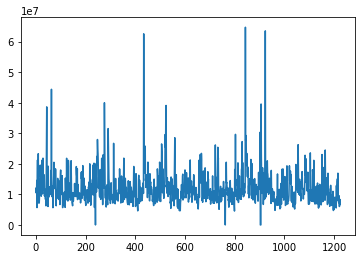

In [11]:
plt.plot(stock_df['Volume'])
#plt.ylim(0,1000000)

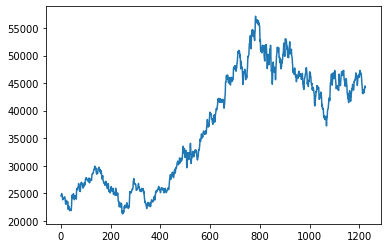

In [12]:
plt.plot(stock_df['average'])

- 거래량과 일별평균주가로 데이터를 만든다

In [13]:
stock = stock_df[['Volume','average']].values
stock.shape

(1224, 2)

### 학습용 데이터 생성

In [14]:
stock.shape

(1224, 2)

In [16]:
lookback = 50 # 50일치 데이터로 시퀀스를 만든다

In [17]:
X = []
y = []

for i in range(len(stock)-lookback):
    X.append(stock[i:i+lookback])
    y.append(stock[i+lookback,[1]])

In [18]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1174, 50, 2), (1174, 1))

In [19]:
X_train = X[:-200-lookback]
X_test = X[-200:]
y_train = y[:-200-lookback]
y_test = y[-200:]

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((924, 50, 2), (200, 50, 2), (924, 1), (200, 1))

- 각 샘플 별로 정규화 적용

In [55]:
X = []
Y = []

for x,y in zip(X_train, y_train):
    x_mean = x.mean(axis=0)
    x_std = x.std(axis=0)
    X.append((x-x_mean)/x_std)
    Y.append([(y[0]-x_mean[1])/x_std[1]])

In [56]:
np.array(X).shape, np.array(Y).shape

((924, 50, 2), (924, 1))

In [59]:
X_train = np.array(X)
y_train = np.array(Y)

In [60]:
X = []
Y = []

for x,y in zip(X_test, y_test):
    x_mean = x.mean(axis=0)
    x_std = x.std(axis=0)
    X.append((x-x_mean)/x_std)
    Y.append([(y[0]-x_mean[1])/x_std[1]])
    
X_test = np.array(X)
y_test = np.array(Y)

In [69]:
X_test.shape, y_test.shape

((200, 50, 2), (200, 1))

### 모델 생성

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization

In [71]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu',
              input_shape=(50,2))) # ReLU 적용 (회귀)
model.add(LSTM(32, return_sequences=True, activation='relu')) # ReLU 적용 (회귀)
model.add(LSTM(32))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 32)            4480      
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(loss='mse', optimizer='adam')

In [73]:
h = model.fit(X_train, y_train, batch_size=32, epochs=20,
              validation_data=(X_test, y_test))

Epoch 1/20
29/29 [==============================] - 29s 307ms/step - loss: 1.9937 - val_loss: 1.4354
Epoch 2/20
29/29 [==============================] - 5s 177ms/step - loss: 0.9651 - val_loss: 0.8269
Epoch 3/20
29/29 [==============================] - 5s 186ms/step - loss: 0.6231 - val_loss: 0.4646
Epoch 4/20
29/29 [==============================] - 5s 180ms/step - loss: 0.4445 - val_loss: 0.3792
Epoch 5/20
29/29 [==============================] - 5s 180ms/step - loss: 0.3577 - val_loss: 0.2681
Epoch 6/20
29/29 [==============================] - 5s 180ms/step - loss: 0.3267 - val_loss: 0.2670
Epoch 7/20
29/29 [==============================] - 6s 192ms/step - loss: 0.2960 - val_loss: 0.2953
Epoch 8/20
29/29 [==============================] - 5s 182ms/step - loss: 0.2178 - val_loss: 0.1628
Epoch 9/20
29/29 [==============================] - 5s 180ms/step - loss: 0.1924 - val_loss: 0.2818
Epoch 10/20
29/29 [==============================] - 5s 182ms/step - loss: 0.2017 - val_loss: 0.192

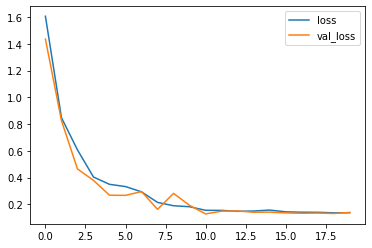

In [74]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])

### 평가

In [75]:
X = []
y = []

for i in range(len(stock)-lookback):
    X.append(stock[i:i+lookback])
    y.append(stock[i+lookback,[1]])

In [76]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1174, 50, 2), (1174, 1))

In [77]:
_X_train = X[:-200-lookback]
_X_test = X[-200:]
_y_train = y[:-200-lookback]
_y_test = y[-200:]

In [78]:
_X_train.shape, _X_test.shape, _y_train.shape, _y_test.shape

((924, 50, 2), (200, 50, 2), (924, 1), (200, 1))

In [79]:
pred_y = model.predict(X_test)
pred_y

array([[-1.5549465e+00],
       [-1.3162442e+00],
       [-1.5493947e+00],
       [-6.4573604e-01],
       [-1.2636739e+00],
       [-9.3980610e-01],
       [-4.8294565e-01],
       [-3.1439286e-01],
       [-5.8131748e-01],
       [-2.3103514e-01],
       [-5.6193095e-01],
       [-2.0083973e-01],
       [-3.2726395e-01],
       [ 1.5276149e-03],
       [-2.8922507e-01],
       [-1.0823207e+00],
       [-1.1834474e+00],
       [-7.9463416e-01],
       [-9.3194443e-01],
       [-8.1712812e-01],
       [-5.4631597e-01],
       [-4.4404873e-01],
       [-1.5438169e-01],
       [-8.7325072e-01],
       [-5.1667124e-01],
       [-1.1362504e+00],
       [-2.0171864e+00],
       [-2.1916254e+00],
       [-1.6644201e+00],
       [-2.4486516e+00],
       [-2.0855503e+00],
       [-2.0201805e+00],
       [-2.0736835e+00],
       [-2.9194186e+00],
       [-2.6423860e+00],
       [-2.5257542e+00],
       [-2.0064616e+00],
       [-2.1329174e+00],
       [-2.2078626e+00],
       [-1.7569087e+00],


In [84]:
real_y = []

for i in range(200):
    x = _X_test[i]
    real_y.append(pred_y[i]*(x.std(axis=0)[1]) + x.mean(axis=0)[1])

In [87]:
real_y = np.array(real_y)

Text(0.5, 1.0, 'Samsung - Stock price')

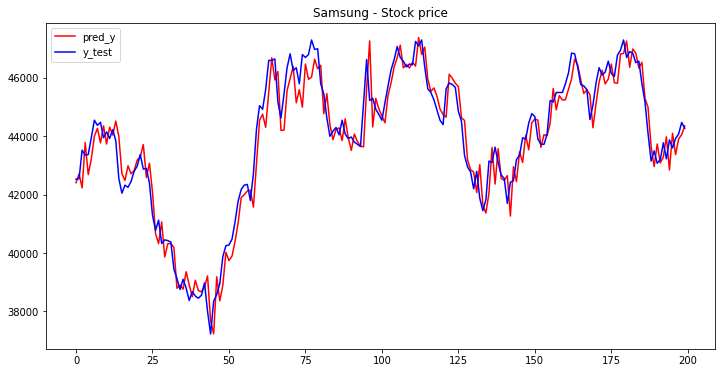

In [99]:
plt.figure(figsize=[12,6])
plt.plot(real_y.ravel(), 'r-', label='pred_y')
plt.plot(_y_test.ravel(), 'b-', label='y_test')
#plt.plot((real_y-_y_test).ravel()*50, 'g-', label='diff*10')
plt.legend()
plt.title('Samsung - Stock price')

- 위의 결과는 그럴듯해 보이지만 사실은 엉터리이다
- 바로 하루전의 주가로 예측한 것일 뿐이다

Text(0.5, 1.0, 'Samsung - Stock price')

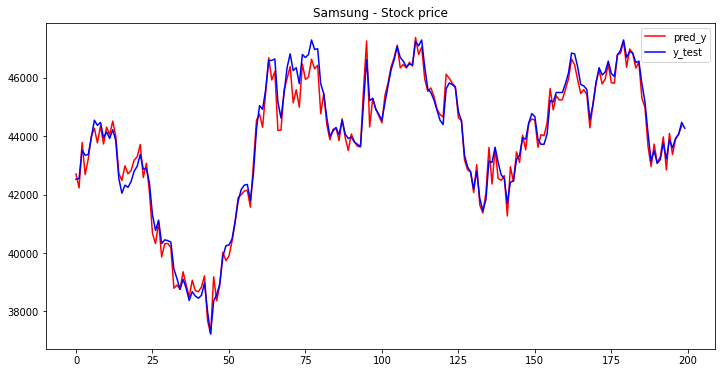

In [101]:
plt.figure(figsize=[12,6])
plt.plot(real_y.ravel()[1:], 'r-', label='pred_y')
plt.plot(_y_test.ravel(), 'b-', label='y_test')
#plt.plot((real_y-_y_test).ravel()*50, 'g-', label='diff*10')
plt.legend()
plt.title('Samsung - Stock price')